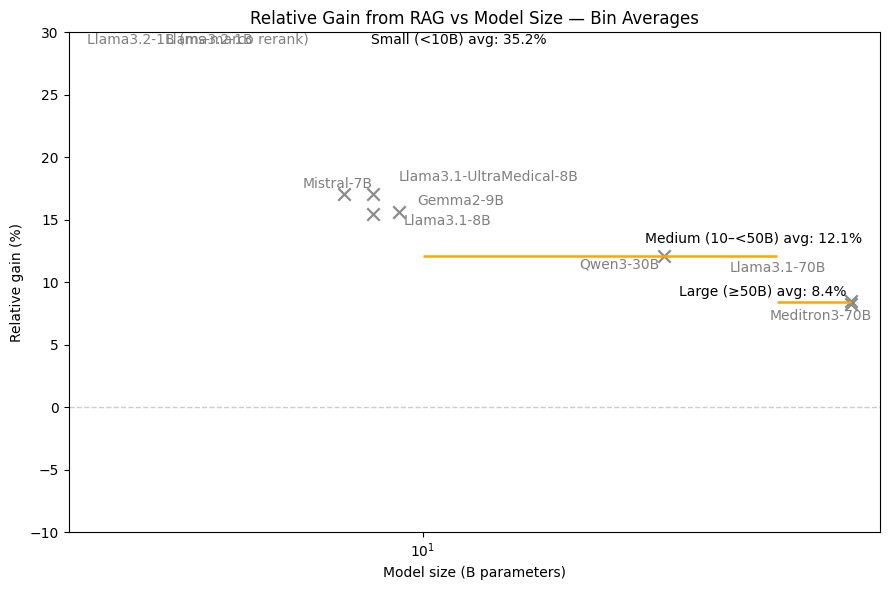

In [64]:
# --- GRAPH RELATIVE GAIN PER SIZE (bin averages + cross markers + labels) ---
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from adjustText import adjust_text

# Input data
data = [
    {'Model': 'Llama3.2-1B', 'Size': 1,  'Acc. no RAG': 26.5, 'Acc. w RAG': 46.8},
    {'Model': 'Mistral-7B', 'Size': 7,  'Acc. no RAG': 50.5, 'Acc. w RAG': 54.2},
    {'Model': 'Gemma2-9B', 'Size': 9,  'Acc. no RAG': 59.5, 'Acc. w RAG': 62.6},
    # {'Model': 'Llama3.1-8B', 'Size': 8, 'Acc. no RAG': 54.9, 'Acc. w RAG': 50.8},
    {'Model': 'Llama3.1-UltraMedical-8B', 'Size': 8, 'Acc. no RAG': 49.7, 'Acc. w RAG': 56.9},
    # {'Model': 'Gemma3-27B', 'Size': 27, 'Acc. no RAG': 62.6, 'Acc. w RAG': 56.3},
    {'Model': 'Qwen3-30B', 'Size': 30, 'Acc. no RAG': 66.1, 'Acc. w RAG': 73.8},
    {'Model': 'Llama3.1-70B', 'Size': 70, 'Acc. no RAG': 70.6, 'Acc. w RAG': 76.6},
    # {'Model': 'Llama3.1-70B-UtraMedical', 'Size': 70, 'Acc. no RAG':63.7, 'Acc. w RAG': 61.1},
]

data = [
    {'Model': 'Llama3.2-1B (ms-marco rerank)', 'Size': 1,  'Acc. no RAG': 26.1, 'Acc. w RAG': 44.1},
    {'Model': 'Llama3.2-1B', 'Size': 1,  'Acc. no RAG': 26.1, 'Acc. w RAG': 46.2},
    {'Model': 'Mistral-7B', 'Size': 7,  'Acc. no RAG': 49.8, 'Acc. w RAG': 58.3},
    {'Model': 'Gemma2-9B', 'Size': 9,  'Acc. no RAG': 58.3, 'Acc. w RAG': 67.4},
    {'Model': 'Llama3.1-8B', 'Size': 8, 'Acc. no RAG': 56.4, 'Acc. w RAG': 65.1},
    {'Model': 'Llama3.1-UltraMedical-8B', 'Size': 8, 'Acc. no RAG': 51.7, 'Acc. w RAG': 60.5},
    # {'Model': 'Gemma3-27B', 'Size': 27, 'Acc. no RAG': 62.6, 'Acc. w RAG': 56.3},
    {'Model': 'Qwen3-30B', 'Size': 30, 'Acc. no RAG': 66.1, 'Acc. w RAG': 74.1},
    {'Model': 'Llama3.1-70B', 'Size': 70, 'Acc. no RAG': 70.6, 'Acc. w RAG': 76.6},
    {'Model': 'Meditron3-70B', 'Size': 70, 'Acc. no RAG': 67.6, 'Acc. w RAG': 73.2},
] #On this one for MedCPT rerank, I do not precise it

df = pd.DataFrame(data)

# Relative gain (%)
df["Delta (pp)"] = df["Acc. w RAG"] - df["Acc. no RAG"]
df["Rel. gain (%)"] = (df["Delta (pp)"] / df["Acc. no RAG"]) * 100

# Bin edges and labels (Medium now <50B)
# edges  = [-np.inf, 2, 10, 50, np.inf]
# labels = ["Very small (<2B)", "Small (2–<10B)", "Medium (10–<50B)", "Large (≥50B)"]

edges  = [-np.inf, 10, 50, np.inf]
labels = ["Small (<10B)", "Medium (10–<50B)", "Large (≥50B)"]

plt.figure(figsize=(9, 6))

ax = plt.gca()
ax.set_xscale('symlog', linthresh=1, linscale=1, base=10)  # linear from 0–1, log above
# ax.set_xlim(right=0)                                        # left edge at 0
ax.margins(x=0.02)                                         # small padding

# 1) All individual models as crosses (grey)
plt.scatter(
    df["Size"], df["Rel. gain (%)"],
    marker="x", color="gray", alpha=0.9, s=80, linewidths=1.6
)

texts = []

# 1a) Model labels (initially at the same (x,y); adjust_text will move them)
for _, r in df.iterrows():
    t = plt.text(r["Size"], r["Rel. gain (%)"], r["Model"], color="gray")
    texts.append(t)

# 2) Horizontal line for each bin at that bin's average (orange + thinner), with bin labels
x_min, x_max = df["Size"].min(), df["Size"].max()
for i, lbl in enumerate(labels):
    left, right = edges[i], edges[i+1]
    mask = (df["Size"] >= left) & (df["Size"] < right)
    if not mask.any():
        continue

    y = df.loc[mask, "Rel. gain (%)"].mean()
    seg_left  = max(x_min, left if np.isfinite(left) else x_min)
    seg_right = min(x_max, right if np.isfinite(right) else x_max)

    plt.hlines(y, seg_left, seg_right, linewidth=1.8, color="orange")
    x_mid = (seg_left + seg_right) / 2

    # place bin label slightly above the line to start
    t = plt.text(x_mid, y, f"{lbl} avg: {y:.1f}%", ha="center", va="bottom")
    texts.append(t)

# Zero line, titles, axes (no grid)
plt.axhline(0, linewidth=1, color="black", linestyle="--", alpha=0.2)
plt.title("Relative Gain from RAG vs Model Size — Bin Averages")
plt.xlabel("Model size (B parameters)")
plt.ylabel("Relative gain (%)")
plt.ylim(-10, 30)
plt.xlim(2, 80)

# --- Automatic text placement to reduce overlaps ---
# Pass point coordinates so texts also avoid crossing the scatter marks.
adjust_text(
    texts,
    x=df["Size"].values,
    y=df["Rel. gain (%)"].values,
    ax=ax,
    autoalign='y',                       # prefer vertical alignment tweaks
    only_move={'points':'y', 'text':'xy'},
    expand_text=(1.05, 1.15),
    expand_points=(1.02, 1.10),
    force_text=0.5,
    force_points=0.3,
    # arrowprops=dict(arrowstyle='-', lw=0.5, alpha=0.3)  # subtle leader lines if moved
)

plt.tight_layout()
plt.show()

C:\Users\orosh\AppData\Local\Temp\ipykernel_9264\3178209842.py:130: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 125)


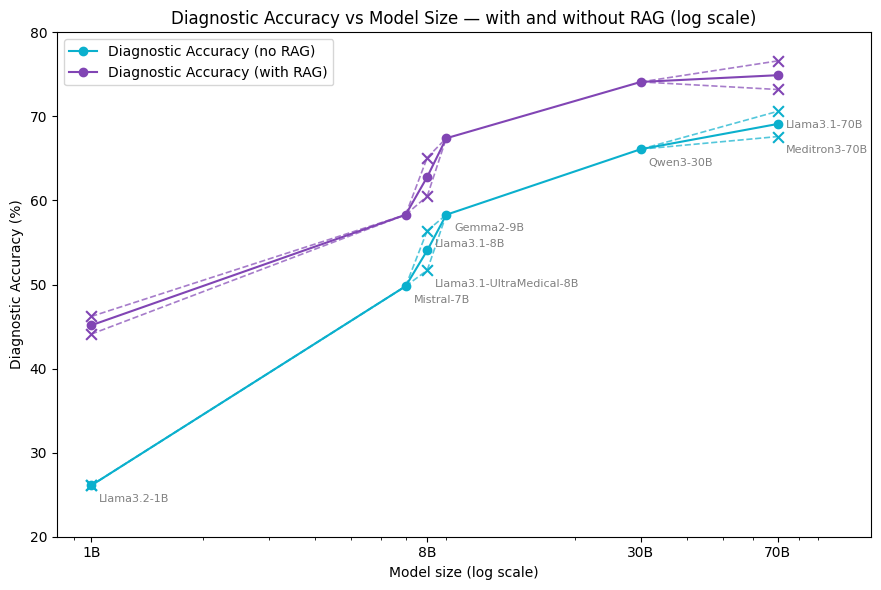

In [65]:
# --- ACCURACY VS MODEL SIZE (means + dashed branches via neighbors for same-size models, log x) ---

import matplotlib.pyplot as plt
import numpy as np

# We reuse `df` from the previous cell

# 1) Compute mean accuracy per model size (for the main solid lines)
grouped = (
    df.groupby("Size", as_index=False)[["Acc. no RAG", "Acc. w RAG"]]
      .mean()
      .sort_values("Size")
)

sizes_unique     = grouped["Size"].values
acc_no_rag_mean  = grouped["Acc. no RAG"].values
acc_w_rag_mean   = grouped["Acc. w RAG"].values

plt.figure(figsize=(9, 6))

color_no_rag = "#0BB0CD"
color_w_rag  = "#8145B4"

# 2) Main solid lines through the per-size means
plt.plot(
    sizes_unique, acc_no_rag_mean,
    "-o", label="Diagnostic Accuracy (no RAG)",
    color=color_no_rag
)
plt.plot(
    sizes_unique, acc_w_rag_mean,
    "-o", label="Diagnostic Accuracy (with RAG)",
    color=color_w_rag
)

# 3) For sizes with multiple models, add dashed "alternative paths"
for size, group in df.groupby("Size"):
    if len(group) <= 1:
        continue

    idx_arr = np.where(sizes_unique == size)[0]
    if len(idx_arr) == 0:
        continue
    idx = idx_arr[0]

    prev_coord_no = prev_coord_w = None
    next_coord_no = next_coord_w = None

    if idx > 0:
        x_prev = sizes_unique[idx - 1]
        prev_coord_no = (x_prev, acc_no_rag_mean[idx - 1])
        prev_coord_w  = (x_prev, acc_w_rag_mean[idx - 1])

    if idx < len(sizes_unique) - 1:
        x_next = sizes_unique[idx + 1]
        next_coord_no = (x_next, acc_no_rag_mean[idx + 1])
        next_coord_w  = (x_next, acc_w_rag_mean[idx + 1])

    for _, row in group.iterrows():
        # --- no RAG branch ---
        y_ind_no = row["Acc. no RAG"]
        if prev_coord_no is not None:
            plt.plot(
                [prev_coord_no[0], size],
                [prev_coord_no[1], y_ind_no],
                linestyle="--", linewidth=1.2,
                color=color_no_rag, alpha=0.7
            )
        if next_coord_no is not None:
            plt.plot(
                [size, next_coord_no[0]],
                [y_ind_no, next_coord_no[1]],
                linestyle="--", linewidth=1.2,
                color=color_no_rag, alpha=0.7
            )
        plt.scatter(
            size, y_ind_no,
            marker="x", s=60,
            color=color_no_rag
        )

        # --- with RAG branch ---
        y_ind_w = row["Acc. w RAG"]
        if prev_coord_w is not None:
            plt.plot(
                [prev_coord_w[0], size],
                [prev_coord_w[1], y_ind_w],
                linestyle="--", linewidth=1.2,
                color=color_w_rag, alpha=0.7
            )
        if next_coord_w is not None:
            plt.plot(
                [size, next_coord_w[0]],
                [y_ind_w, next_coord_w[1]],
                linestyle="--", linewidth=1.2,
                color=color_w_rag, alpha=0.7
            )
        plt.scatter(
            size, y_ind_w,
            marker="x", s=60,
            color=color_w_rag
        )

# 4) Add model labels only for the no-RAG points, in gray, bottom-right offset
for _, row in df.iterrows():
    x = row["Size"]
    y_no = row["Acc. no RAG"]

    #If contains parentheses, skip label
    if "(" in row["Model"] and ")" in row["Model"]:
        continue

    plt.text(
        x * 1.05,        # move slightly to the right (log scale -> multiplicative)
        y_no - 1.0,      # a bit below the point
        row["Model"],
        color="gray",
        fontsize=8,
        ha="left",
        va="top"
    )

# 5) Cosmetics + log x-axis with custom ticks
plt.xscale("log")
plt.xlabel("Model size (log scale)")
plt.ylabel("Diagnostic Accuracy (%)")
plt.title("Diagnostic Accuracy vs Model Size — with and without RAG (log scale)")
plt.ylim(20, 80)
# plt.xlim(df["Size"].min() * 0.8, df["Size"].max() * 1.2)
plt.xlim(0, 125)

# Only show specific ticks on the log-x axis
plt.xticks([1, 8, 30, 70], ["1B", "8B", "30B", "70B"])

plt.legend()
plt.tight_layout()
plt.show()


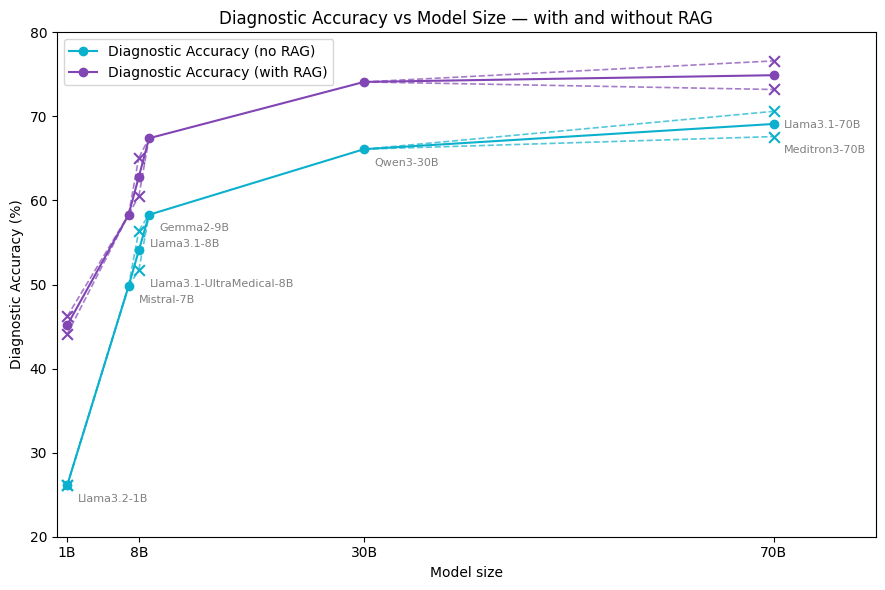

In [66]:
# --- ACCURACY VS MODEL SIZE (means + dashed branches via neighbors for same-size models, log x) ---

import matplotlib.pyplot as plt
import numpy as np

# We reuse `df` from the previous cell

# 1) Compute mean accuracy per model size (for the main solid lines)
grouped = (
    df.groupby("Size", as_index=False)[["Acc. no RAG", "Acc. w RAG"]]
      .mean()
      .sort_values("Size")
)

sizes_unique     = grouped["Size"].values
acc_no_rag_mean  = grouped["Acc. no RAG"].values
acc_w_rag_mean   = grouped["Acc. w RAG"].values

plt.figure(figsize=(9, 6))

color_no_rag = "#0BB0CD"
color_w_rag  = "#8145B4"

# 2) Main solid lines through the per-size means
plt.plot(
    sizes_unique, acc_no_rag_mean,
    "-o", label="Diagnostic Accuracy (no RAG)",
    color=color_no_rag
)
plt.plot(
    sizes_unique, acc_w_rag_mean,
    "-o", label="Diagnostic Accuracy (with RAG)",
    color=color_w_rag
)

# 3) For sizes with multiple models, add dashed "alternative paths"
for size, group in df.groupby("Size"):
    if len(group) <= 1:
        continue

    idx_arr = np.where(sizes_unique == size)[0]
    if len(idx_arr) == 0:
        continue
    idx = idx_arr[0]

    prev_coord_no = prev_coord_w = None
    next_coord_no = next_coord_w = None

    if idx > 0:
        x_prev = sizes_unique[idx - 1]
        prev_coord_no = (x_prev, acc_no_rag_mean[idx - 1])
        prev_coord_w  = (x_prev, acc_w_rag_mean[idx - 1])

    if idx < len(sizes_unique) - 1:
        x_next = sizes_unique[idx + 1]
        next_coord_no = (x_next, acc_no_rag_mean[idx + 1])
        next_coord_w  = (x_next, acc_w_rag_mean[idx + 1])

    for _, row in group.iterrows():
        # --- no RAG branch ---
        y_ind_no = row["Acc. no RAG"]
        if prev_coord_no is not None:
            plt.plot(
                [prev_coord_no[0], size],
                [prev_coord_no[1], y_ind_no],
                linestyle="--", linewidth=1.2,
                color=color_no_rag, alpha=0.7
            )
        if next_coord_no is not None:
            plt.plot(
                [size, next_coord_no[0]],
                [y_ind_no, next_coord_no[1]],
                linestyle="--", linewidth=1.2,
                color=color_no_rag, alpha=0.7
            )
        plt.scatter(
            size, y_ind_no,
            marker="x", s=60,
            color=color_no_rag
        )

        # --- with RAG branch ---
        y_ind_w = row["Acc. w RAG"]
        if prev_coord_w is not None:
            plt.plot(
                [prev_coord_w[0], size],
                [prev_coord_w[1], y_ind_w],
                linestyle="--", linewidth=1.2,
                color=color_w_rag, alpha=0.7
            )
        if next_coord_w is not None:
            plt.plot(
                [size, next_coord_w[0]],
                [y_ind_w, next_coord_w[1]],
                linestyle="--", linewidth=1.2,
                color=color_w_rag, alpha=0.7
            )
        plt.scatter(
            size, y_ind_w,
            marker="x", s=60,
            color=color_w_rag
        )

# 4) Add model labels only for the no-RAG points, in gray, bottom-right offset
for _, row in df.iterrows():
    x = row["Size"]
    y_no = row["Acc. no RAG"]

    #If contains parentheses, skip label
    if "(" in row["Model"] and ")" in row["Model"]:
        continue

    plt.text(
        x + 1.05,        # move slightly to the right (log scale -> multiplicative)
        y_no - 1.0,      # a bit below the point
        row["Model"],
        color="gray",
        fontsize=8,
        ha="left",
        va="top"
    )

# 5) Cosmetics + log x-axis with custom ticks
# plt.xscale("log")
plt.xlabel("Model size")
plt.ylabel("Diagnostic Accuracy (%)")
plt.title("Diagnostic Accuracy vs Model Size — with and without RAG")
plt.ylim(20, 80)
# plt.xlim(df["Size"].min() * 0.8, df["Size"].max() * 1.2)
plt.xlim(0, 80)

# Only show specific ticks on the log-x axis
plt.xticks([1, 8, 30, 70], ["1B", "8B", "30B", "70B"])

plt.legend()
plt.tight_layout()
plt.show()


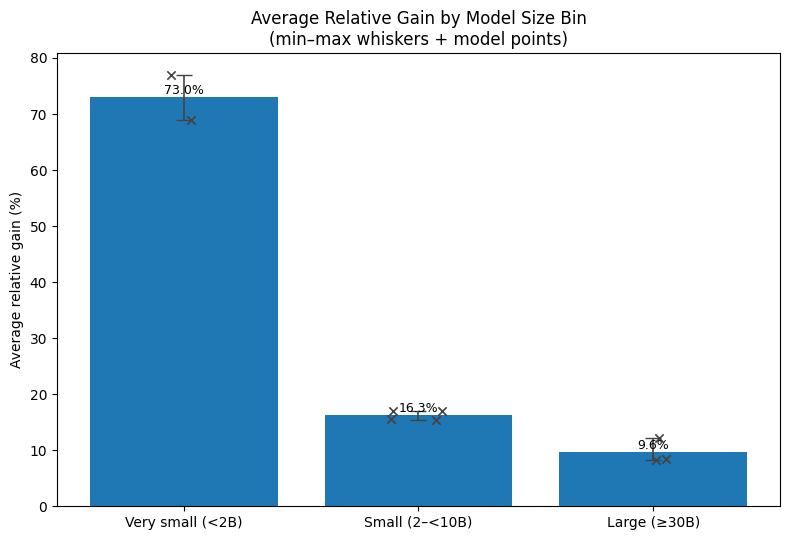

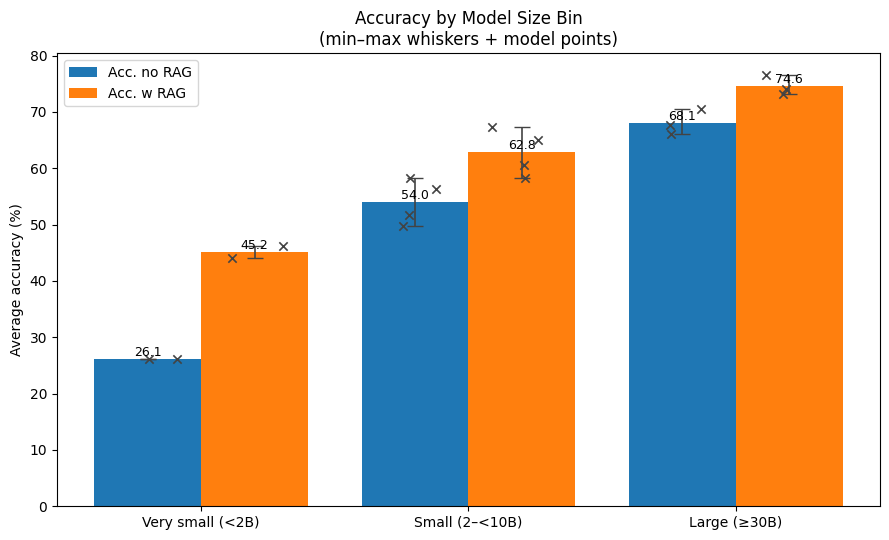

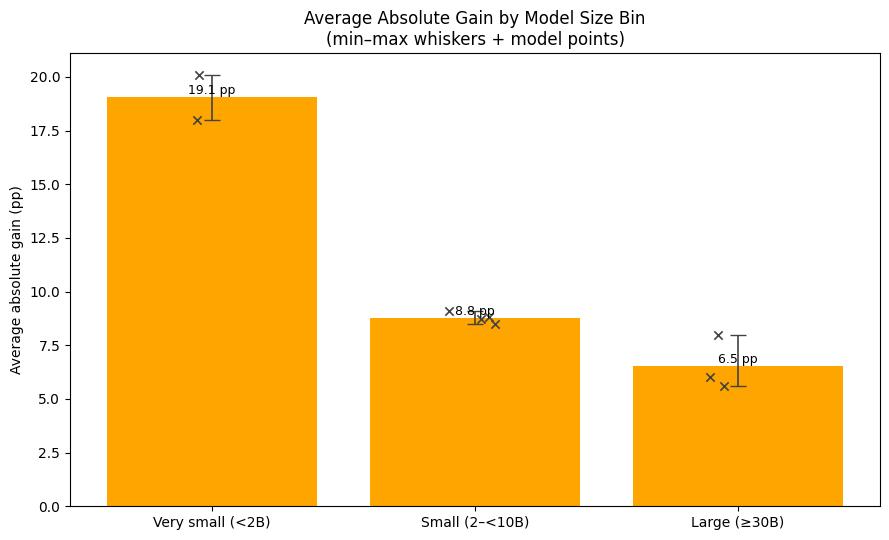

In [70]:
# --- Build category labels from size ---
# Bin edges and labels (Medium now <50B)
# edges  = [-np.inf, 2, 10, 50, np.inf]
# labels = ["Very small (<2B)", "Small (2–<10B)", "Medium (10–<50B)", "Large (≥50B)"]

edges  = [-np.inf, 2, 10, np.inf]
labels = ["Very small (<2B)", "Small (2–<10B)", "Large (≥30B)"]

# edges  = [-np.inf, 10, 50, np.inf]
# labels = ["Small (<10B)", "Medium (10–<50B)", "Large (≥50B)"]
df["Category"] = pd.cut(df["Size"], bins=edges, labels=labels, right=False)

# --- Per-category means (for order) ---
cat_rel_gain = df.groupby("Category", observed=True)["Rel. gain (%)"].mean()
cat_accs     = df.groupby("Category", observed=True)[["Acc. no RAG", "Acc. w RAG"]].mean()

import numpy as np
import matplotlib.pyplot as plt

GRAY = "#434343"  # mid gray for points + whiskers

# ===============================
# FIGURE 2: relative gain (bars) +
#           min–max whiskers + points (mid gray)
# ===============================
rel_stats = df.groupby("Category", observed=True)["Rel. gain (%)"].agg(["mean", "min", "max"])
rel_stats = rel_stats.reindex(cat_rel_gain.index)

plt.figure(figsize=(8, 5.5))
x = np.arange(len(rel_stats.index))
means = rel_stats["mean"].values
mins  = rel_stats["min"].values
maxs  = rel_stats["max"].values

# Bars (category means)
plt.bar(x, means)

# Min–max whiskers (thin mid gray)
lower = means - mins
upper = maxs - means
plt.errorbar(
    x, means, yerr=[lower, upper],
    fmt="none", ecolor=GRAY, elinewidth=1.2, capsize=6
)

# Overlay the real points as mid-gray crosses
rng = np.random.default_rng(0)
for i, cat in enumerate(rel_stats.index):
    vals = df.loc[df["Category"] == cat, "Rel. gain (%)"].values
    if len(vals) == 0:
        continue
    jitter = rng.uniform(-0.12, 0.12, size=len(vals))
    plt.scatter(
        np.full(len(vals), i) + jitter, vals,
        marker="x", c=GRAY, linewidths=1.2, zorder=3
    )

plt.xticks(x, rel_stats.index)
plt.ylabel("Average relative gain (%)")
plt.title("Average Relative Gain by Model Size Bin\n(min–max whiskers + model points)")
for i, v in enumerate(means):
    plt.text(i, v, f"{v:.1f}%", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

# ==============================================
# FIGURE 3: accuracies (two bars per category) +
#           min–max whiskers + points (mid gray)
# ==============================================
acc_aggs = df.groupby("Category", observed=True).agg({
    "Acc. no RAG": ["mean", "min", "max"],
    "Acc. w RAG" : ["mean", "min", "max"]
})
acc_aggs.columns = ["no_mean","no_min","no_max","w_mean","w_min","w_max"]
acc_aggs = acc_aggs.reindex(cat_accs.index)

plt.figure(figsize=(9, 5.5))
x = np.arange(len(acc_aggs.index))
w = 0.4

# Bars (keep default fills)
plt.bar(x - w/2, acc_aggs["no_mean"].values, width=w, label="Acc. no RAG")
plt.bar(x + w/2, acc_aggs["w_mean"].values,  width=w, label="Acc. w RAG")

# Min–max whiskers for each bar (thin mid gray)
no_mean = acc_aggs["no_mean"].values
w_mean  = acc_aggs["w_mean"].values
plt.errorbar(
    x - w/2, no_mean,
    yerr=[no_mean - acc_aggs["no_min"].values, acc_aggs["no_max"].values - no_mean],
    fmt="none", ecolor=GRAY, elinewidth=1.2, capsize=6
)
plt.errorbar(
    x + w/2, w_mean,
    yerr=[w_mean - acc_aggs["w_min"].values, acc_aggs["w_max"].values - w_mean],
    fmt="none", ecolor=GRAY, elinewidth=1.2, capsize=6
)

# Overlay real points as mid-gray crosses near each bar
rng = np.random.default_rng(1)
for i, cat in enumerate(acc_aggs.index):
    subset = df[df["Category"] == cat]
    if subset.empty:
        continue
    # no RAG (left bar)
    jit_no = rng.uniform(-0.12, 0.12, size=len(subset))
    plt.scatter(
        np.full(len(subset), x[i] - w/2) + jit_no, subset["Acc. no RAG"],
        marker="x", c=GRAY, linewidths=1.2, zorder=3
    )
    # with RAG (right bar)
    jit_w  = rng.uniform(-0.12, 0.12, size=len(subset))
    plt.scatter(
        np.full(len(subset), x[i] + w/2) + jit_w, subset["Acc. w RAG"],
        marker="x", c=GRAY, linewidths=1.2, zorder=3
    )

plt.xticks(x, acc_aggs.index)
plt.ylabel("Average accuracy (%)")
plt.title("Accuracy by Model Size Bin\n(min–max whiskers + model points)")

# plt.ylim(0, 100)

for i, v in enumerate(no_mean):
    plt.text(x[i] - w/2, v, f"{v:.1f}", ha="center", va="bottom", fontsize=9)
for i, v in enumerate(w_mean):
    plt.text(x[i] + w/2, v, f"{v:.1f}", ha="center", va="bottom", fontsize=9)
plt.legend()
plt.tight_layout()
plt.show()


# Graph average (not relative) gain per size category
# First compute per-model absolute gain
df["Abs gain (pp)"] = df["Acc. w RAG"] - df["Acc. no RAG"]

# Aggregate stats per category: mean, min, max of absolute gain
gain_stats = df.groupby("Category", observed=True)["Abs gain (pp)"].agg(["mean", "min", "max"])
gain_stats = gain_stats.reindex(cat_accs.index)

plt.figure(figsize=(9, 5.5))
x = np.arange(len(gain_stats.index))

means = gain_stats["mean"].values
mins  = gain_stats["min"].values
maxs  = gain_stats["max"].values

# Bars: mean absolute gain per bin
plt.bar(
    x,
    means,
    color="#FFA500"
)

# Min–max whiskers (thin mid-gray, reusing GRAY defined above)
lower = means - mins
upper = maxs - means
plt.errorbar(
    x, means,
    yerr=[lower, upper],
    fmt="none",
    ecolor=GRAY,
    elinewidth=1.2,
    capsize=6
)

# Overlay the individual model absolute gains as mid-gray crosses with jitter
rng = np.random.default_rng(2)
for i, cat in enumerate(gain_stats.index):
    vals = df.loc[df["Category"] == cat, "Abs gain (pp)"].values
    if len(vals) == 0:
        continue
    jitter = rng.uniform(-0.12, 0.12, size=len(vals))
    plt.scatter(
        np.full(len(vals), i) + jitter,
        vals,
        marker="x",
        c=GRAY,
        linewidths=1.2,
        zorder=3
    )

plt.xticks(x, gain_stats.index)
plt.ylabel("Average absolute gain (pp)")
plt.title("Average Absolute Gain by Model Size Bin\n(min–max whiskers + model points)")

for i, v in enumerate(means):
    plt.text(i, v, f"{v:.1f} pp", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


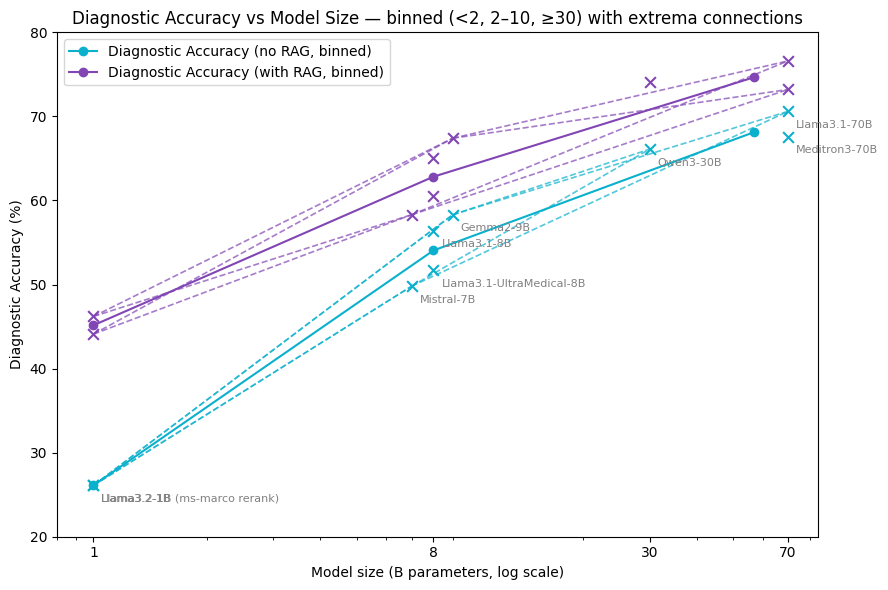

In [68]:
# --- BINNED VERSION: <2, 2–10, ≥30 with extrema-only dashed connections ---

import matplotlib.pyplot as plt
import numpy as np

# We reuse `df` from the previous cell

# Define bins by conditions
bin_specs = [
    {"name": "<2B",   "mask": df["Size"] < 2},
    {"name": "2–10B", "mask": (df["Size"] >= 2) & (df["Size"] < 10)},
    {"name": "≥30B",  "mask": df["Size"] >= 30},
]

bins_used = []

for spec in bin_specs:
    bin_df = df.loc[spec["mask"]].copy()
    if bin_df.empty:
        continue

    # Main line (bin means)
    center_x   = bin_df["Size"].mean()
    mean_no    = bin_df["Acc. no RAG"].mean()
    mean_w     = bin_df["Acc. w RAG"].mean()

    # Extremes in diagnostic accuracy (min & max) for no-RAG
    col_no = bin_df["Acc. no RAG"]
    min_no, max_no = col_no.min(), col_no.max()
    ext_no_df = bin_df[(col_no == min_no) | (col_no == max_no)]
    extremes_no = ext_no_df[["Size", "Acc. no RAG"]].to_numpy()

    # Extremes in diagnostic accuracy (min & max) for with-RAG
    col_w = bin_df["Acc. w RAG"]
    min_w, max_w = col_w.min(), col_w.max()
    ext_w_df = bin_df[(col_w == min_w) | (col_w == max_w)]
    extremes_w = ext_w_df[["Size", "Acc. w RAG"]].to_numpy()

    bins_used.append({
        "name": spec["name"],
        "center_x": center_x,
        "mean_no": mean_no,
        "mean_w": mean_w,
        "extremes_no": extremes_no,
        "extremes_w": extremes_w,
    })

# Extract main-line arrays
bin_centers     = np.array([b["center_x"] for b in bins_used])
bin_acc_no_mean = np.array([b["mean_no"]   for b in bins_used])
bin_acc_w_mean  = np.array([b["mean_w"]    for b in bins_used])

plt.figure(figsize=(9, 6))

color_no_rag = "#0BB0CD"
color_w_rag  = "#8145B4"

# 1) Main solid lines through bin means
plt.plot(
    bin_centers, bin_acc_no_mean,
    "-o", label="Diagnostic Accuracy (no RAG, binned)",
    color=color_no_rag
)
plt.plot(
    bin_centers, bin_acc_w_mean,
    "-o", label="Diagnostic Accuracy (with RAG, binned)",
    color=color_w_rag
)

# 2) Dashed lines ONLY between extrema of adjacent bins (not to main points)
for i in range(len(bins_used) - 1):
    b_curr = bins_used[i]
    b_next = bins_used[i + 1]

    # no-RAG extrema connections
    for x1, y1 in b_curr["extremes_no"]:
        for x2, y2 in b_next["extremes_no"]:
            plt.plot(
                [x1, x2], [y1, y2],
                linestyle="--", linewidth=1.2,
                color=color_no_rag, alpha=0.7
            )

    # with-RAG extrema connections
    for x1, y1 in b_curr["extremes_w"]:
        for x2, y2 in b_next["extremes_w"]:
            plt.plot(
                [x1, x2], [y1, y2],
                linestyle="--", linewidth=1.2,
                color=color_w_rag, alpha=0.7
            )

# 3) Scatter all individual points
plt.scatter(
    df["Size"], df["Acc. no RAG"],
    marker="x", s=60, color=color_no_rag, label="_nolegend_"
)
plt.scatter(
    df["Size"], df["Acc. w RAG"],
    marker="x", s=60, color=color_w_rag, label="_nolegend_"
)

# 4) Labels only for no-RAG points, gray, bottom-right offset
for _, row in df.iterrows():
    x = row["Size"]
    y_no = row["Acc. no RAG"]

    plt.text(
        x * 1.05,        # a bit to the right (log scale)
        y_no - 1.0,      # a bit below
        row["Model"],
        color="gray",
        fontsize=8,
        ha="left",
        va="top"
    )

# 5) Cosmetics + log x-axis with custom ticks
plt.xscale("log")
plt.xlabel("Model size (B parameters, log scale)")
plt.ylabel("Diagnostic Accuracy (%)")
plt.title("Diagnostic Accuracy vs Model Size — binned (<2, 2–10, ≥30) with extrema connections")
plt.ylim(20, 80)
plt.xlim(df["Size"].min() * 0.8, df["Size"].max() * 1.2)

plt.xticks([1, 8, 30, 70], ["1", "8", "30", "70"])

plt.legend()
plt.tight_layout()
plt.show()
